Device being used: cuda


C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Train Acc: 0.5432 - Val Acc: 0.6461
Epoch 2/20 - Train Acc: 0.6432 - Val Acc: 0.6152
Epoch 3/20 - Train Acc: 0.7191 - Val Acc: 0.7042
Epoch 4/20 - Train Acc: 0.7586 - Val Acc: 0.6279
Epoch 5/20 - Train Acc: 0.8309 - Val Acc: 0.6515
Epoch 6/20 - Train Acc: 0.8364 - Val Acc: 0.7187
Epoch 7/20 - Train Acc: 0.8727 - Val Acc: 0.7260
Epoch 8/20 - Train Acc: 0.9077 - Val Acc: 0.7005
Epoch 9/20 - Train Acc: 0.9077 - Val Acc: 0.7042
Epoch 10/20 - Train Acc: 0.9150 - Val Acc: 0.6679
Epoch 11/20 - Train Acc: 0.9314 - Val Acc: 0.7205
Epoch 12/20 - Train Acc: 0.9418 - Val Acc: 0.7078
Epoch 13/20 - Train Acc: 0.9523 - Val Acc: 0.7260
Epoch 14/20 - Train Acc: 0.9473 - Val Acc: 0.7114
Epoch 15/20 - Train Acc: 0.9509 - Val Acc: 0.6969
Epoch 16/20 - Train Acc: 0.9605 - Val Acc: 0.7332
Epoch 17/20 - Train Acc: 0.9591 - Val Acc: 0.7314
Epoch 18/20 - Train Acc: 0.9659 - Val Acc: 0.7132
Epoch 19/20 - Train Acc: 0.9727 - Val Acc: 0.6878
Epoch 20/20 - Train Acc: 0.9618 - Val Acc: 0.7024


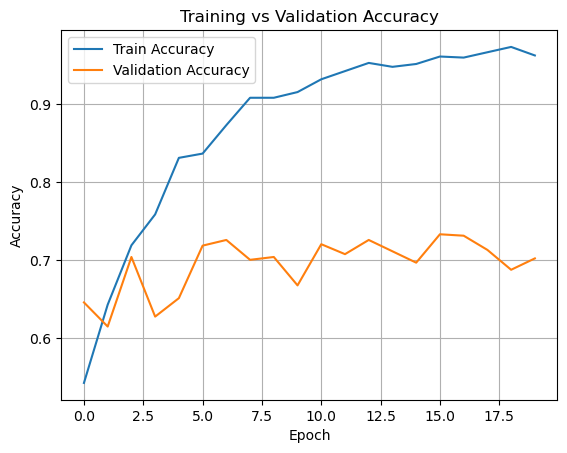

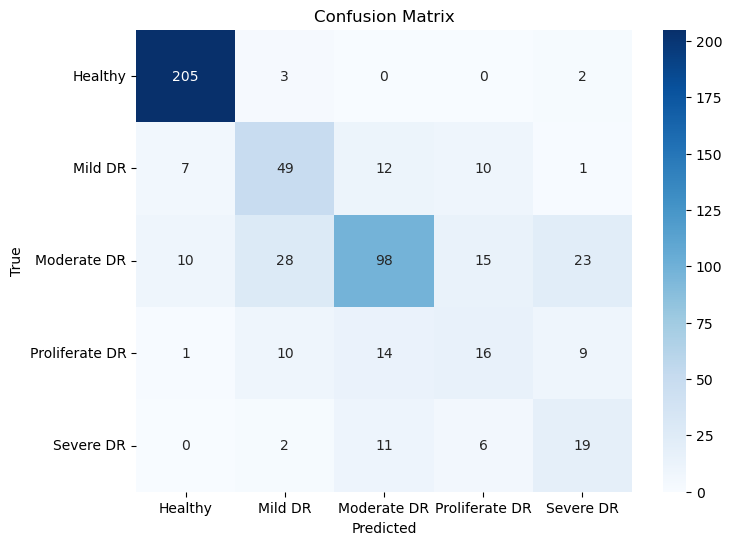


Classification Report:
                 precision    recall  f1-score   support

       Healthy       0.92      0.98      0.95       210
       Mild DR       0.53      0.62      0.57        79
   Moderate DR       0.73      0.56      0.63       174
Proliferate DR       0.34      0.32      0.33        50
     Severe DR       0.35      0.50      0.41        38

      accuracy                           0.70       551
     macro avg       0.57      0.60      0.58       551
  weighted avg       0.71      0.70      0.70       551



In [1]:
#06-05-2025
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import cv2

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

# Set dataset path
data_dir = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"

# Image transformations with augmentation
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
dataset = datasets.ImageFolder(data_dir, transform=transform["train"])

# Train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_ds.dataset.transform = transform["train"]
val_ds.dataset.transform = transform["val"]

# Compute class weights to handle imbalance
targets = [label for _, label in train_ds]
class_sample_count = np.array([targets.count(t) for t in np.unique(targets)])
class_weights = 1. / class_sample_count
weights = [class_weights[t] for t in targets]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

# Load pretrained VGG16
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier
model.classifier[6] = nn.Linear(4096, 5)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)

# Training loop
train_acc_history, val_acc_history = [], []
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_ds)
    epoch_acc = running_corrects.double() / len(train_ds)
    train_acc_history.append(epoch_acc.item())

    # Validation
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_ds)
    val_acc_history.append(val_acc.item())

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {epoch_acc:.4f} - Val Acc: {val_acc:.4f}")

# Plot training and validation accuracy
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.show()

# Confusion matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
classes = dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))


In [2]:
# Save state_dict (recommended way)
torch.save(model.state_dict(), "vgg16_dr_state_dict.pth")

# Optionally: Save full model
torch.save(model, "vgg16_dr_full_model.pth")
print("Model saved successfully.")


Model saved successfully.


C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


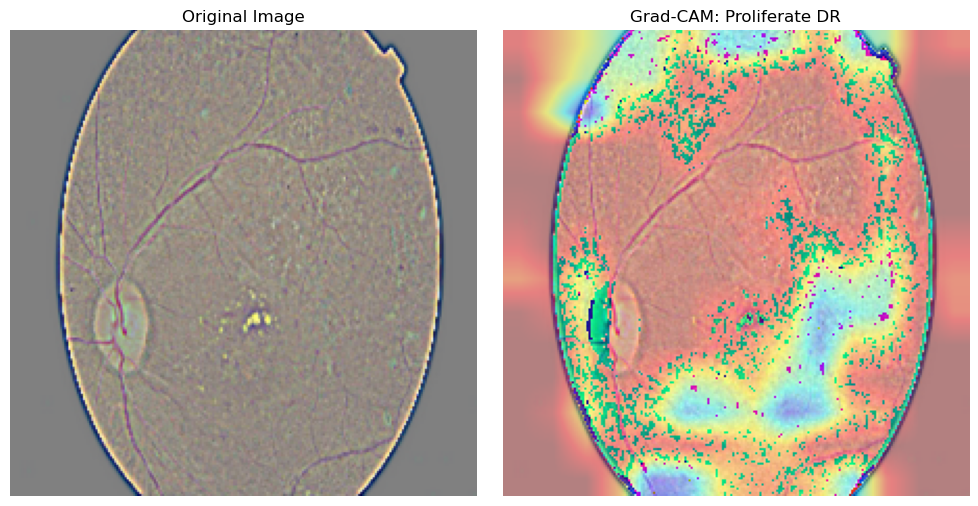

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class names
class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']

# Load trained model
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 5)
model.load_state_dict(torch.load("vgg16_dr_state_dict.pth"))
model.to(device)
model.eval()

# Global hooks
gradients = []
activations = []

def generate_gradcam(model, image_path, class_names):
    gradients.clear()
    activations.clear()

    # Preprocess image
    img = Image.open(image_path).convert('RGB')
    transform_input = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform_input(img).unsqueeze(0).to(device)

    # Hook the correct layer: VGG16 last conv layer is features[29]
    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    handle_fw = model.features[29].register_forward_hook(forward_hook)
    handle_bw = model.features[29].register_backward_hook(backward_hook)

    # Forward and backward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    class_label = class_names[pred_class]
    score = output[0, pred_class]
    model.zero_grad()
    score.backward()

    handle_fw.remove()
    handle_bw.remove()

    if not gradients or not activations:
        print("Error: Gradients or Activations not captured.")
        return

    # Grad-CAM calculation
    grads = gradients[0]
    acts = activations[0]
    weights = grads.mean(dim=[2, 3], keepdim=True)
    cam = (weights * acts).sum(dim=1).squeeze()
    cam = torch.clamp(cam, min=0)
    cam = cam / cam.max()

    cam = cam.cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    img_original = np.array(img.resize((224, 224)))
    overlayed = heatmap * 0.4 + img_original

    # Show
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img_original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM: {class_label}")
    plt.imshow(np.uint8(overlayed))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run on a sample image
sample_path = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Proliferate DR\Proliferate DR_15.png"
generate_gradcam(model, sample_path, class_names)
